In [1]:
import numpy as np
import pandas as pd
import re

from gensim.models import Word2Vec

C:\Users\Marwan Kamel\Anaconda3\envs\py36\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\Marwan Kamel\Anaconda3\envs\py36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Loading the Metadata file to a pandas DataFrame

The metadata file contains genral information about the movie like name, genre(s) and tagline

In [2]:
df_metadata = pd.read_csv('../movies_metadata.csv')

df_metadata

C:\Users\Marwan Kamel\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
5,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
6,False,NaN,58000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0
7,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,45325,tt0112302,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",...,1995-12-22,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Original Bad Boys.,Tom and Huck,False,5.4,45.0
8,False,NaN,35000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,1995-11-16,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0


In this project we are excluding the movies that do not have a genre, since it is the main label and the only independant variable. We are also excluding movies without overviews or taglines, namely our main inputs.

In [3]:
has_genres_mask = df_metadata['genres'] != '[]'
has_tagline_mask = df_metadata['tagline'] != None
has_overview_mask = df_metadata['overview'] != None

df_metadata_dense = df_metadata[has_genres_mask][['id','original_title','genres','overview','tagline']]
df_metadata_dense = df_metadata_dense[~pd.isnull(df_metadata_dense['tagline']) & ~pd.isnull(df_metadata_dense['overview'])]
df_metadata_dense

,id,original_title,genres,overview,tagline
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...
5,949,Heat,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...","Obsessive master thief, Neil McCauley leads a ...",A Los Angeles Crime Saga
6,11860,Sabrina,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",An ugly duckling having undergone a remarkable...,You are cordially invited to the most surprisi...
7,45325,Tom and Huck,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","A mischievous young boy, Tom Sawyer, witnesses...",The Original Bad Boys.
8,9091,Sudden Death,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",International action superstar Jean Claude Van...,Terror goes into overtime.
9,710,GoldenEye,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",James Bond must unmask the mysterious head of ...,No limits. No fears. No substitutes.
10,9087,The American President,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Widowed U.S. president Andrew Shepherd, one of...",Why can't the most powerful man in the world h...


In [9]:
#assign separate datafram for inputs and outputs
genres = df_metadata_dense['genres']
overviews = df_metadata_dense['overview']
taglines = df_metadata_dense['tagline']

Problem: The genres are stored as a string, containing a list of dictionaries. Each dictionary describes the id and name of a genre of the given movie.

To treat this, we use ast library to evaluate the string and output a machine readable list of dictionaries

In [5]:
import ast
def to_labels(genres_list):
    genres_list = ast.literal_eval(genres_list)
    return [g['name'] for g in genres_list]

In [6]:
def replace_double_words(input_list):
    genres_list = input_list
    if 'TV Movie' in genres_list:
        genres_list.remove('TV Movie')
        genres_list.append('TVMovie')
    
    if 'Science Fiction' in genres_list:
        genres_list.remove('Science Fiction')
        genres_list.append('ScienceFiction')
    
    return genres_list

In [10]:
genres = genres.apply(to_labels)
genres.head(n=50)

1                    [Adventure, Fantasy, Family]
2                               [Romance, Comedy]
3                        [Comedy, Drama, Romance]
4                                        [Comedy]
5                [Action, Crime, Drama, Thriller]
6                               [Comedy, Romance]
7              [Action, Adventure, Drama, Family]
8                   [Action, Adventure, Thriller]
9                   [Adventure, Action, Thriller]
10                       [Comedy, Drama, Romance]
12                 [Family, Animation, Adventure]
13                               [History, Drama]
14                            [Action, Adventure]
15                                 [Drama, Crime]
16                               [Drama, Romance]
17                                [Crime, Comedy]
18                     [Crime, Comedy, Adventure]
19                        [Action, Comedy, Crime]
20                      [Comedy, Thriller, Crime]
21                              [Drama, Thriller]


In [11]:
genres = genres.apply(replace_double_words)
genres.head(n=30)

1                   [Adventure, Fantasy, Family]
2                              [Romance, Comedy]
3                       [Comedy, Drama, Romance]
4                                       [Comedy]
5               [Action, Crime, Drama, Thriller]
6                              [Comedy, Romance]
7             [Action, Adventure, Drama, Family]
8                  [Action, Adventure, Thriller]
9                  [Adventure, Action, Thriller]
10                      [Comedy, Drama, Romance]
12                [Family, Animation, Adventure]
13                              [History, Drama]
14                           [Action, Adventure]
15                                [Drama, Crime]
16                              [Drama, Romance]
17                               [Crime, Comedy]
18                    [Crime, Comedy, Adventure]
19                       [Action, Comedy, Crime]
20                     [Comedy, Thriller, Crime]
21                             [Drama, Thriller]
22          [Action,

# Genre Encoding (Bag Of Words)

Since the genres will be used as labels in our case, there is no need to search for underlying relations between different genres (ie. A BOW model would be sufficient to indicate inclusion or exclusion of a given genre)

In [12]:
distinct_genres = list(set([genre for listing in genres for genre in listing]))

distinct_genres

['Drama',
 'Music',
 'Horror',
 'Foreign',
 'Thriller',
 'Adventure',
 'Mystery',
 'TVMovie',
 'Western',
 'Documentary',
 'Family',
 'Romance',
 'Animation',
 'Action',
 'ScienceFiction',
 'Fantasy',
 'Crime',
 'Comedy',
 'History',
 'War']

The next two cells show how to train a BOW model on all the genres in the training set; and how to encode the labels of a given movie in a single fixed size array.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(distinct_genres)

print(genres.tolist()[0])
result = vectorizer.transform(genres.tolist()[0]).toarray()
print(result)
print(vectorizer.vocabulary_)

['Adventure', 'Fantasy', 'Family']
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]
{'drama': 6, 'music': 12, 'horror': 11, 'foreign': 9, 'thriller': 16, 'adventure': 1, 'mystery': 13, 'tvmovie': 17, 'western': 19, 'documentary': 5, 'family': 7, 'romance': 14, 'animation': 2, 'action': 0, 'sciencefiction': 15, 'fantasy': 8, 'crime': 4, 'comedy': 3, 'history': 10, 'war': 18}


In [14]:
final = np.zeros(result[0].shape)
for i in range(len(result)):
    final+= result[i]

final

array([0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

The output above is a sample of what the output of the system would be. The array size indicates the number of distinct genres there are; the presence or absence of a 1 in a given index indicates whether the movie is of this genre.

# Visualisations

In [15]:
genres_count = []
for genre in distinct_genres:
    count=0
    for movie in genres.values:
        if genre in movie:
            count +=1
    genres_count.append(count)

genres_count

[9050,
 838,
 3160,
 321,
 4756,
 2115,
 1425,
 207,
 683,
 1156,
 1466,
 3414,
 718,
 3877,
 1971,
 1259,
 2606,
 6241,
 608,
 655]

In [15]:
count_sum = np.sum(genres_count)
percentages_genres = [100*(count/count_sum) for count in genres_count]
percentages_genres, np.sum(percentages_genres)

([0.6899368095258566,
  4.545845333791858,
  7.337832609723595,
  1.4078149851695827,
  13.41400507243262,
  3.1509263637536,
  8.332975110690796,
  4.236340970640072,
  10.222241327429824,
  5.60116923870524,
  3.06280359368955,
  2.4846322486351715,
  1.4679963891157632,
  1.8011434466749774,
  0.44491252203069254,
  1.5432231440484891,
  6.7919013024975285,
  2.7060138417229074,
  19.45148948974767,
  1.306796199974208],
 99.99999999999999)

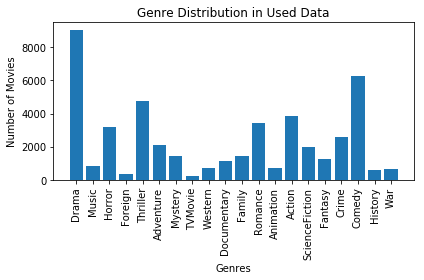

In [57]:
import matplotlib.pyplot as plt
data = np.hstack((distinct_genres, genres_count))

plt.bar(distinct_genres,genres_count)
plt.title("Genre Distribution in Used Data")
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

# Overview Encoding (Word2Vec Embeddings)

We are using Google News pretrained Word2Vec model as our word embeddings model. The reason is that this model is trained on more than 3 billion articles which represent semantic meaning of words better than training our own model on domain specific data.

In [16]:
from gensim.models import KeyedVectors

In [17]:
goognews_wordvec = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin.gz', binary=True, limit=200000)

In [18]:
goognews_wordvec.most_similar('genre')

[('genres', 0.7803478837013245),
 ('subgenre', 0.7772022485733032),
 ('horror_genre', 0.7067170143127441),
 ('Genre', 0.5810316801071167),
 ('indie', 0.5755900144577026),
 ('cinematic', 0.5729672908782959),
 ('genre_bending', 0.571851372718811),
 ('sci_fi', 0.5534889698028564),
 ('noir', 0.5489354133605957),
 ('oeuvre', 0.5460532903671265)]

In [19]:
goognews_wordvec.wv['Myself'].shape

C:\Users\Marwan Kamel\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


(300,)

# Preprocessing of Input(s)

Now that we defined how we are going to encode out data (input/output); last step before building a model is the cleaning of our data 'preprocessing'. Since one of our methods invlolves building a Neural Network, it is encouraged to keep preprocessing to a minimum.  

The method below, 'clean', applies preprocessing on the overview and tagline fields of an input.

note: The code snippet below is used from assignment 2 provided material

In [20]:
def clean(text, stem_words=True):
    import string
    from string import punctuation
    #from nltk.stem import SnowballStemmer
    #from nltk.corpus import stopwords
    
    # Not null value but empty (unlikely due to preprocessing done on removing empty values previously)
    if type(text) != str or text=='':
        return ''

    # Clean the text (here i have 2-3 cases of pre-processing by sampling the data. You might need more)
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    
    
    #make text lower case
    text = text.lower()
    
    #remove punctutation
    text = text.translate(str.maketrans('', '', string.punctuation))

    
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    
    
    # Return a list of words
    return text

In [21]:
clean("If the heat doesn't kill you, something else will") #random example from the dataset

'if the heat doesnt kill you something else will'

In [22]:
taglines = df_metadata_dense['tagline'].apply(clean)
overviews = df_metadata_dense['overview'].apply(clean)

overviews, taglines

(1        when siblings judy and peter discover an encha...
 2        a family wedding reignites the ancient feud be...
 3        cheated on mistreated and stepped on the women...
 4        just when george banks has recovered from his ...
 5        obsessive master thief neil mccauley leads a t...
 6        an ugly duckling having undergone a remarkable...
 7        a mischievous young boy tom sawyer witnesses a...
 8        international action superstar jean claude van...
 9        james bond must unmask the mysterious head of ...
 10       widowed us president andrew shepherd one of th...
 12       an outcast halfwolf risks his life to prevent ...
 13       an allstar cast powers this epic look at ameri...
 14       morgan adams and her slave william shaw are on...
 15       the life of the gambling paradise – las vegas ...
 16       rich mr dashwood dies leaving his second wife ...
 17       it  ted the bellhop  first night on the joband...
 18       summoned from an ashram in tib

In [23]:
#This is a function that encodes the labels using the BOW model trained earlier
def encode_BOW(genreslist):
    result = vectorizer.transform(genreslist).toarray()
    final = np.zeros(result[0].shape)
    for i in range(len(result)):
        final+= result[i]
        
    return final

genres_BOW = np.array([encode_BOW(item) for item in genres.values])
genres_BOW.shape

(20139, 20)

Now we have the target labels ready.

Next: use word embeddings to represent the cleaned overviews and taglines

First we tokenize, remove the stopwords (imported from nltk).
The goal from this, as seen in the output of the cell below, is to obtain lists of words that are more likely to be associated with the genre. Since we are not using Tf-idf vectorization, it is important to remove words that would bias the probability distribution.

In [24]:
from nltk import word_tokenize
from nltk.corpus import stopwords

#First tokenize the text in overviews and taglines
overviews_tokens = [word_tokenize(s) for s in overviews]
taglines_tokens = [word_tokenize(s) for s in taglines]

stop_words = stopwords.words('english')
overviews_tokens = [[word for word in sentence if word not in stop_words] for sentence in overviews_tokens]
taglines_tokens = [[word for word in sentence if word not in stop_words] for sentence in taglines_tokens]

overviews_tokens

[['siblings',
  'judy',
  'peter',
  'discover',
  'enchanted',
  'board',
  'game',
  'opens',
  'door',
  'magical',
  'world',
  'unwittingly',
  'invite',
  'alan',
  'adult',
  'trapped',
  'inside',
  'game',
  '26',
  'years',
  'living',
  'room',
  'alan',
  'hope',
  'freedom',
  'finish',
  'game',
  'proves',
  'risky',
  'three',
  'find',
  'running',
  'giant',
  'rhinoceroses',
  'evil',
  'monkeys',
  'terrifying',
  'creatures'],
 ['family',
  'wedding',
  'reignites',
  'ancient',
  'feud',
  'nextdoor',
  'neighbors',
  'fishing',
  'buddies',
  'john',
  'max',
  'meanwhile',
  'sultry',
  'italian',
  'divorcée',
  'opens',
  'restaurant',
  'local',
  'bait',
  'shop',
  'alarming',
  'locals',
  'worry',
  'shell',
  'scare',
  'fish',
  'away',
  'less',
  'interested',
  'seafood',
  'cooking',
  'hot',
  'time',
  'max'],
 ['cheated',
  'mistreated',
  'stepped',
  'women',
  'holding',
  'breath',
  'waiting',
  'elusive',
  'good',
  'man',
  'break',
  'st

Final part of our Data Cleaning and Preparation part: Word embeddings of input. This is simple thanks to the word embeddings loaded earlier from Google News.

Here we just loop through the words in each sentence, and replace it with its embedding from the word dictionary. In the (rare) case that a word is not in the vocabulary, we will drop it from the list.

In [25]:
from gensim.models import Word2Vec

custom_wordvec = Word2Vec(overviews_tokens)

custom_wordvec.train(overviews_tokens, total_examples=20139, epochs=custom_wordvec.epochs)

(2777534, 3107220)

In [26]:
def load_embedding(sentence, model):
    vector = np.array([])
    for w in sentence:
        try:
            vector = np.append(vector, model.wv[w])
        except:
            pass
    return vector

In [27]:
from keras.preprocessing.sequence import pad_sequences

overviews_embeddings = [load_embedding(s, custom_wordvec) for s in overviews_tokens]
taglines_embeddings = [load_embedding(s, custom_wordvec) for s in taglines_tokens]

overviews_embeddings = pad_sequences(overviews_embeddings, dtype='f8', maxlen=2000)
taglines_embeddings = pad_sequences(taglines_embeddings, dtype='f8', maxlen=2000)

taglines_embeddings

Using TensorFlow backend.
C:\Users\Marwan Kamel\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


array([[ 0.        ,  0.        ,  0.        , ..., -0.12792969,
        -0.06152344, -0.2578125 ],
       [-0.140625  ,  0.05712891,  0.14746094, ..., -0.19824219,
        -0.12304688,  0.06494141],
       [ 0.        ,  0.        ,  0.        , ..., -0.48046875,
         0.12988281,  0.04443359],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.125     ,
        -0.05615234, -0.10839844],
       [ 0.        ,  0.        ,  0.        , ..., -0.08300781,
         0.06542969, -0.02941895],
       [ 0.        ,  0.        ,  0.        , ..., -0.08984375,
        -0.34570312,  0.16992188]])

In [28]:
taglines_embeddings.shape

(20139, 2000)

Great! Now we have achieved fixed length embeddings for overviews and taglines. This is very important since the whole sequence for each sentence (e.g one plot summary) can be fed through a network as it is without averaging retaining all the information.

In [29]:
overviews_train, overviews_test = overviews_embeddings[:19100], overviews_embeddings[19100:]
taglines_train, taglines_test = taglines_embeddings[:19100], taglines_embeddings[19100:]
genres_train, genres_test = genres_BOW[:19100], genres_BOW[19100:]

In [30]:
BOW_input_model = CountVectorizer()
BOW_input_model.fit(overviews.tolist()+taglines.tolist())

overviews_BOW = BOW_input_model.transform(overviews)
overviews_BOW_train, overviews_BOW_test= overviews_BOW[:19100], overviews_BOW[19100:]

overviews_BOW_train.shape

(19100, 53667)

In [31]:
X_train_trial = [np.hstack((overviews_train[i], taglines_train[i])) for i in range(len(taglines_train))]
X_test_trial = [np.hstack((overviews_test[i], taglines_test[i])) for i in range(len(taglines_test))]

In [32]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_trial, genres_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
predictions = model.predict(X_test_trial)
predictions.shape

(1039, 20)

In [34]:
def estimate_output(exact_output):
    predictions_post = [[1.0 if genre>0.4 else 0.0 for genre in prediction] for prediction in exact_output]
    return predictions_post

In [35]:
### TODO: Write the new evaluation method, distance between sublist of true label and sublist of predicted label
def accuracy_method(predictions_post):
    import difflib
    pred_binary = []
    test_binary = []
    for i in range(len(predictions_post)):
        predict=[]
        testing=[]
        for j in range(len(distinct_genres)):
            if (predictions_post[i][j]==1 or genres_test.tolist()[i][j]==1):
                predict.append(predictions_post[i][j])
                testing.append(genres_test.tolist()[i][j])
    
        pred_binary.append(predict)
        test_binary.append(testing)

    sum=0
    for i in range(len(pred_binary)):
        sum+= difflib.SequenceMatcher(None,pred_binary[i],test_binary[i]).ratio()

    print("accuracy: {}".format(sum/len(predictions_post)))

In [36]:
accuracy_method(estimate_output(predictions))

accuracy: 0.5300643934185807


# SVM Model per Genre based Classification

In this section we will define 20 (number of genres in the dataset) svm models. Each model would predict whether an overview and a tagline belong to the corresponding genre (binary classification).

In [40]:
overviews_embeddings_svm = pad_sequences(overviews_embeddings, dtype='f8', maxlen=100)
taglines_embeddings_svm = pad_sequences(taglines_embeddings, dtype='f8', maxlen=100)

overviews_train_svm, overviews_test_svm = overviews_embeddings_svm[:19100], overviews_embeddings_svm[19100:]
taglines_train_svm, taglines_test_svm = taglines_embeddings_svm[:19100], taglines_embeddings_svm[19100:]

In [41]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

classifiers = []
for i in range(len(distinct_genres)):
    clf = SVC(gamma='scale')
    clf.fit(overviews_train_svm,genres_train[:,i])
    classifiers.append(clf)

In [43]:
predictions_svms=[]
for j in range(len(overviews_test_svm)):
    movie_prediction=[]
    for i in range(len(distinct_genres)):
        movie_prediction.append(classifiers[i].predict([overviews_test_svm[j]])[0])
    predictions_svms.append(movie_prediction)
    
predictions_svms

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,

In [44]:
accuracy_method(predictions_svms)

accuracy: 0.24727301892845693


# K Nearest Neighbours

In this section we use a K nearest neighbours model to output the 5 most similar movie overviews to an input, and set their corresponding genre label as 1 in the output list

In [77]:
overviews_train_1=[]
genres_train_1=[]
overviews_test_1=[]
genres_test_1=[]

for i in range(len(overviews_train)):
    for j in range(20):
        #if (genres_train[j]==1):
        if (genres_train[i][j]==1):
            overviews_train_1.append(overviews_train[i])
            #genres_train_1[i].append(j)
            genres_train_1.append(j)
            
for i in range(len(overviews_test)):
    for j in range(20):
        if (genres_test[i][j]==1):
            overviews_test_1.append(overviews_test[i])
            genres_test_1.append(j)
#samples = [[0., 0., 0.], [0., .5, 0.], [1., 1., .5]]
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(overviews_train_1)

five_prediction=[]
for i in range(len(overviews_test)):
    five_prediction.append([])
    for j in range(20):
        five_prediction[i].append(0)
        
for i in range(len(overviews_test)):
    count_genres=[]
    count_genres=neigh.kneighbors(overviews_test[i],return_distance=False)
    for j in range(5):
        five_prediction[i][genres_train_1[count_genres[0][j]]]=1

In [78]:
accuracy_method(five_prediction)

accuracy: 0.4487125135585175


# LSTM RNN Regressor for sequence prediction

In [43]:
overviews_BOW_train = overviews_BOW_train.reshape(19100,1,53667)

overviews_BOW_train.shape

(19100, 1, 53667)

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

regressor = Sequential()
regressor.add(LSTM(50, input_shape=(1,53667), activation='relu'))
regressor.add(Dense(20, activation='sigmoid'))
regressor.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
regressor.fit(overviews_BOW_train, genres_train, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
19100/19100 [==============================] - 116s 6ms/sample - loss: 0.1120 - acc: 0.2946
Epoch 2/10
19100/19100 [==============================] - 118s 6ms/sample - loss: 0.0736 - acc: 0.4751
Epoch 3/10
19100/19100 [==============================] - 114s 6ms/sample - loss: 0.0601 - acc: 0.5265
Epoch 4/10
19100/19100 [==============================] - 112s 6ms/sample - loss: 0.0491 - acc: 0.5536
Epoch 5/10
19100/19100 [==============================] - 109s 6ms/sample - loss: 0.0396 - acc: 0.5517
Epoch 6/10
19100/19100 [==============================] - 108s 6ms/sample - loss: 0.0332 - acc: 0.5590
Epoch 7/10
19100/19100 [==============================] - 107s 6ms/sample - loss: 0.0283 - acc: 0.5857
Epoch 8/10
19100/19100 [==============================] - 109s 6ms/sample - loss: 0.0235 - acc: 0.6066
Epoch 9/10
19100/19100 [==============================] - 107s 6ms/sample - loss: 0.0191 - acc: 0.6098
Epoch 10/10
19100/19100 [==============================] - 106s 6ms/sampl

In [46]:
overviews_test_lstm = overviews_BOW_test.toarray().reshape(1039,1,53667)

overviews_test_lstm.shape

(1039, 1, 53667)

In [49]:
regressor.evaluate(overviews_test_lstm, genres_test)

1039/1039 [==============================] - 1s 1ms/sample - loss: 0.0762 - acc: 0.4148


[0.07618531939699974, 0.41482195]

In [50]:
genres_train.shape

(19100, 20)

In [52]:
predictions = regressor.predict(overviews_test_lstm)

modified_predictions = estimate_output(predictions)
accuracy_method(modified_predictions)

accuracy: 0.5700352903432788


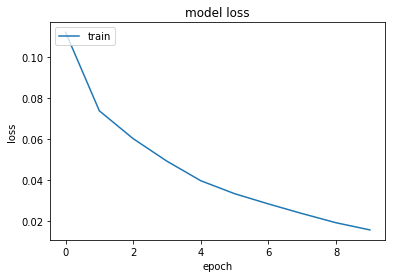

In [59]:
history = regressor.history
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Milestone: LSTM, BOW, 0.5 sequence prediction accuracy, subject to progress.

TODO: Make Deep LSTM network, dropout layers to avoid overfitting